Qiskit Lab 6

Ryan Dougherty

In [4]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Statevector

import numpy as np
import matplotlib.pyplot as plt

# Part 1

### Step A) Creating the given Oracle and assembling it into a gate 

Oracle Circuit:


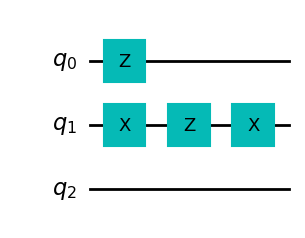

In [5]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')
myqc.x(1)
myqc.z(range(2))
myqc.x(1)

Oracle = myqc.to_gate()
print("Oracle Circuit:")
myqc.draw(output='mpl')

Fetching tagged states from Oracle:

In [6]:
qc = QuantumCircuit(m)
qc.h(range(m)) 
qc.append(Oracle, range(m))

oracle_ket = Statevector(qc)
oracle_ket_dict = oracle_ket.to_dict()
oracle_ket_dict

{'000': (-0.3535533905932737+0j),
 '001': (0.3535533905932737+0j),
 '010': (0.3535533905932737+0j),
 '011': (-0.3535533905932737+0j),
 '100': (-0.3535533905932737+0j),
 '101': (0.3535533905932737+0j),
 '110': (0.3535533905932737+0j),
 '111': (-0.3535533905932737+0j)}

Next, I create the diffuser to be used alongside this Oracle

Diffuser Circuit:


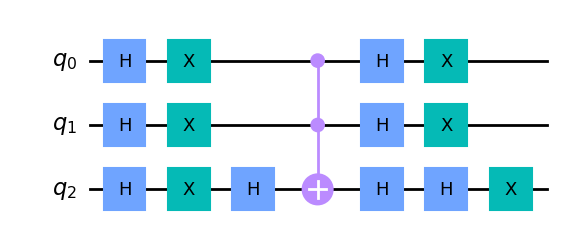

In [7]:
## Create Diffuser
qc_diffuser = QuantumCircuit(m, name='Diffuser')

qc_diffuser.h(range(m))
qc_diffuser.x(range(m))

# Apply multi controlled z on all qubits
qc_diffuser.h(m-1)
qc_diffuser.mct(list(range(m-1)), m-1)
qc_diffuser.h(m-1)

qc_diffuser.h(range(m))
qc_diffuser.x(range(m))

Diffuser = qc_diffuser.to_gate()
print("Diffuser Circuit:")
qc_diffuser.draw(output='mpl')

Lastly, I add both the oracle and diffuser into a single Grover gate

Grover Circuit:


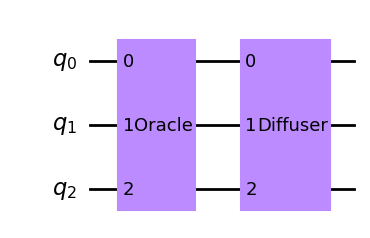

In [8]:
## Create Grover itteration with oracle and diffuser combined
qc = QuantumCircuit(m, name="Grover")

qc.append(Oracle, range(m))
qc.append(Diffuser, range(m))

Grover = qc.to_gate()
C_Grover = Grover.control()

print("Grover Circuit:")
qc.draw(output='mpl')

### Step B) Using the quantum counting algorithm to estimate the amount of solutions our Oracle has

In [9]:
from qiskit.circuit.library import QFT

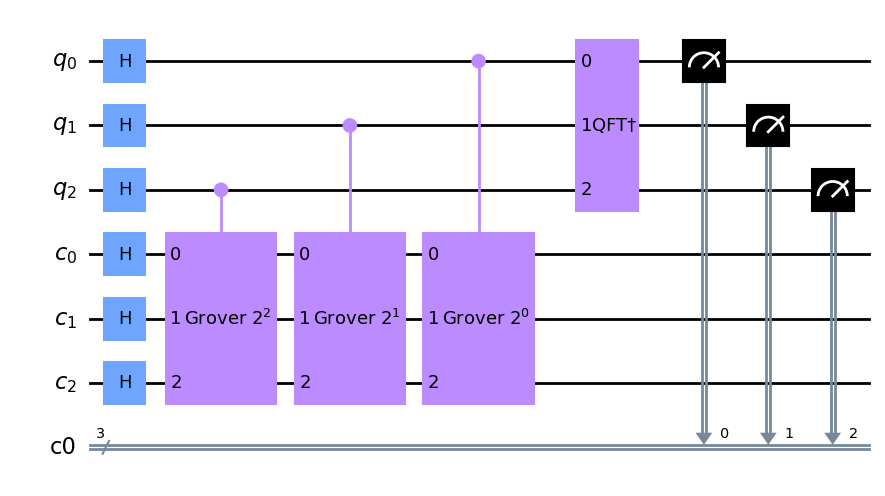

In [10]:
# Controlled gate of Groversm applied 2^k times
def CGrover_pow(k):
    qr = QuantumRegister(m)
    qc= QuantumCircuit(qr)

    for i in range(2**k):
        qc.append(Grover, range(m))

    grover_exp = qc.to_gate()
    grover_exp.name = "Grover $2^{}$".format(k)

    CGrover_k = grover_exp.control()
    return CGrover_k

m = 3
qft = QFT(m)
qft_inv = qft.to_gate().inverse()
qft_inv.label = "QFT†"

# Initialize computational and countting bits
comp_r = QuantumRegister(m, 'q')
count_r = QuantumRegister(m, 'c')
out_r = ClassicalRegister(m)

circ = QuantumCircuit(comp_r, count_r, out_r)

# Put all qubits into a superposition
circ.h(comp_r)
circ.h(count_r)

for k in reversed(range(m)):
    control_reg = [comp_r[k]]
    target_regs = [cbit for cbit in count_r]
    circ.append(CGrover_pow(k), control_reg + target_regs)

circ.append(qft_inv, comp_r)

circ.measure(comp_r, out_r)

circ.draw(output="mpl")

### Step C) Executing the quantum counting algorithm to find the eigenvalues of our solution

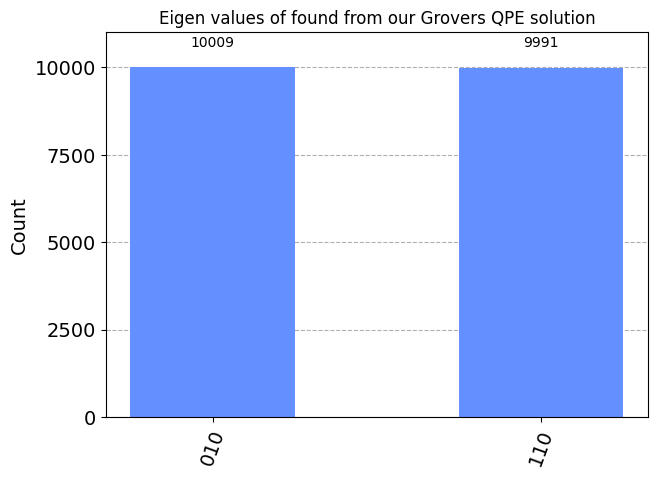

In [11]:
sim = Aer.get_backend('aer_simulator')
shots = 20000
results = execute(circ, backend=sim, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts, title="Eigen values of found from our Grovers QPE solution")

In [12]:

measured_str = max(counts, key=counts.get)
measured_int = int(measured_str, 2)
print("Register output: {}".format(measured_int))

Register output: 2


In [13]:
m = 3
theta = (measured_int / (2**m)) * np.pi * 2
print("Estimated theta: {:.2f}".format(theta))

Estimated theta: 1.57


Lastly we use our theta value to estimate the number of solutions

In [14]:
m = 3
N = 2**m
M_Oracle1 = N * (np.sin(theta/2)**2)
print("Number of solutions: {:.2f}".format(N-M_Oracle1))

Number of solutions: 4.00


In [15]:
m = 3 - 1 # Upper bound: Will be less than this 
N = 2**m
err = (np.sqrt(2*M_Oracle1*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 1.54


# Part 2

### Step A) Let's verify that theta decreases as M goes from N/2 -> N

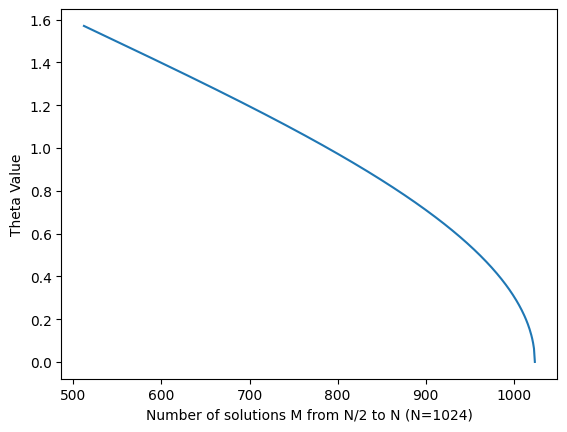

In [16]:
# Let total solutions (N) be 10
M_vals = []
theta_vals = []

N = 2**10
for M in range(N // 2, N+1):
    theta = np.arcsin(2 * np.sqrt(M*(N - M)) / N)
    M_vals.append(M)
    theta_vals.append(theta)

plt.plot(M_vals, theta_vals)
plt.title("")
plt.xlabel("Number of solutions M from N/2 to N (N={})".format(N))
plt.ylabel("Theta Value")
plt.show()

### Step B) Let's see how many iterations are required to get the best theta estimate

In [17]:
m = 3
N = 2**m
theta = np.arcsin((2 * np.sqrt(M_Oracle1*(N - M_Oracle1))) / N)
R_frac = np.arccos(np.sqrt(M_Oracle1 / N)) / theta
print("Number of required iterations (R) for M={:.2f}: {}".format(M_Oracle1, round(R_frac)))
print("R before rounding: {}".format(R_frac))

Number of required iterations (R) for M=4.00: 1
R before rounding: 0.5000000000000001


# 2 

### Step A) New oracle constructed from our previous oravcle. Done so by controlling on the last qubit |q> when its value is zero

Oracle_New Circuit:


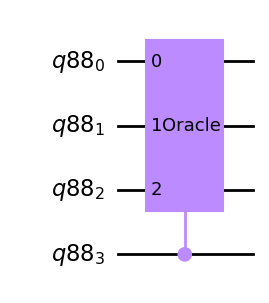

In [32]:
N = 16 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

qr = QuantumRegister(m)
myqc = QuantumCircuit(qr, name='Oracle_New')

COracle = Oracle.control()
# myqc.x(m-1)
myqc.append(COracle, [3,0,1,2])
# myqc.x(m-1)
Oracle_New = myqc.to_gate()


print("Oracle_New Circuit:")
myqc.draw(output="mpl")

In [19]:
qc = QuantumCircuit(m)
qc.h(range(m)) 
qc.append(Oracle_New, range(m))

ket = Statevector(qc)
ket_dict = ket.to_dict()
print(ket_dict)
 
tagged_values = [ket.real for ket in ket_dict.values() if ket.real < 0]
M_OracleNew = len(tagged_values)
print("Number of solutions: {:.2f}".format(M_OracleNew))

{'0000': (-0.24999999999999983+0j), '0001': (0.24999999999999983+0j), '0010': (0.24999999999999983+0j), '0011': (-0.24999999999999983+0j), '0100': (-0.24999999999999983+0j), '0101': (0.24999999999999983+0j), '0110': (0.24999999999999983+0j), '0111': (-0.24999999999999983+0j), '1000': (0.24999999999999983+0j), '1001': (0.24999999999999983+0j), '1010': (0.24999999999999983+0j), '1011': (0.24999999999999983+0j), '1100': (0.24999999999999983+0j), '1101': (0.24999999999999983+0j), '1110': (0.24999999999999983+0j), '1111': (0.24999999999999983+0j)}
Number of solutions: 4.00


### Step B) Now I calculate the number of Grover iterations (R) needed to solve this oracle with M=4 solutions

In [20]:
m = 4
N = 2**m# the number of total items in the search space

theta = np.arcsin(2 * np.sqrt(M_OracleNew*(N - M_OracleNew)) / N)
R_frac = np.arccos(np.sqrt(M_OracleNew / N)) / theta
print("Number of required iterations (R): {}".format(round(R_frac)))
print("R value before rounding: {}".format(R_frac))

Number of required iterations (R): 1
R value before rounding: 1.0000000000000002


### Step C) Creating a diffuser and simulating grovers on this oracle with R=1 iterations

New Diffuser Circuit:


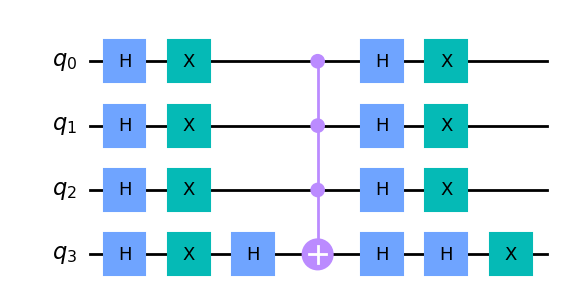

In [21]:
m = 4
N = 2**m


## Create Diffuser
qc_diffuser = QuantumCircuit(m, name='Diffuser_New')

qc_diffuser.h(range(m))
qc_diffuser.x(range(m))

# Apply multi controlled z on all qubits
qc_diffuser.h(m-1)
qc_diffuser.mct(list(range(m-1)), m-1)
qc_diffuser.h(m-1)

qc_diffuser.h(range(m))
qc_diffuser.x(range(m))

Diffuser_New = qc_diffuser.to_gate()
print("New Diffuser Circuit:")
qc_diffuser.draw(output='mpl')

New Grover Circuit:


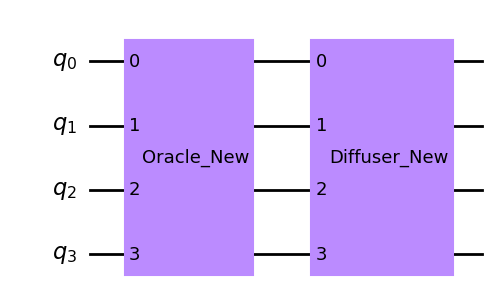

In [34]:
## Create Grover itteration with oracle and diffuser combined
qc = QuantumCircuit(m, name="Grover_New")

qc.append(Oracle_New, range(m))
qc.append(Diffuser_New, range(m))

Grover_New = qc.to_gate()

print("New Grover Circuit:")
qc.draw(output='mpl')

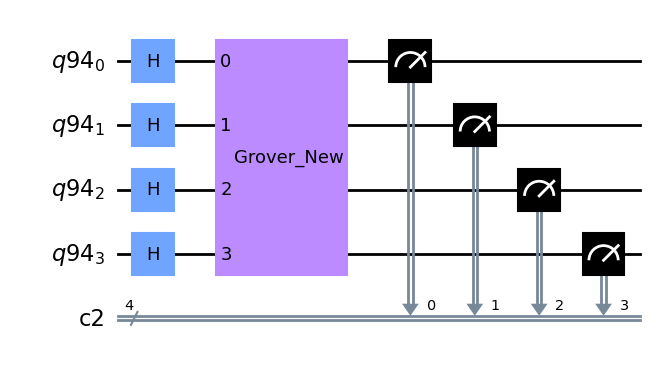

In [35]:
qr = QuantumRegister(m)
cr = ClassicalRegister(m)

qc_final = QuantumCircuit(qr,cr)
qc_final.h(range(m))
qc_final.append(Grover_New, range(m))
qc_final.measure(qr, cr)
##########################

qc_final.draw(output="mpl")

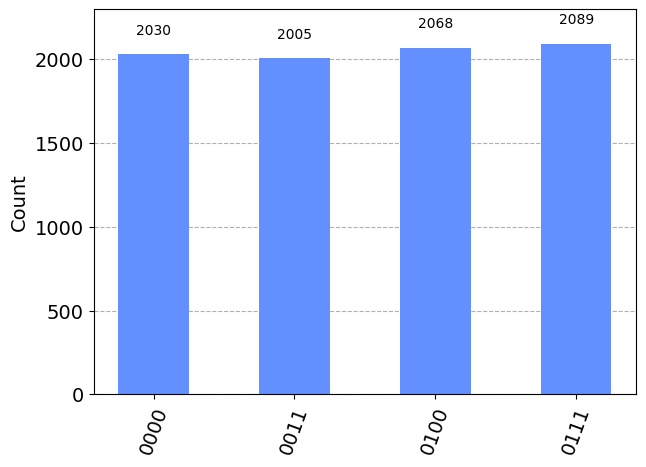

In [36]:
qc_final_trans = transpile(qc_final, sim)
counts_sim = sim.run(qc_final_trans, shots=shots).result().get_counts()
plot_histogram(counts_sim)

### Step D) Verifying that these are the correct solutions from our initial oracle

In [37]:
oracle_solutions = [ket for ket, amp in oracle_ket_dict.items() if amp.real < 0]
print("Solutions from our inital oracle: {}".format(oracle_solutions))

Solutions from our inital oracle: ['000', '011', '100', '111']


In [38]:
new_oracle_solutions = [ket for ket, ket_count in counts_sim.items()]
print("Solutions from our new oracle ran with R=1 iterations of Grovers: {}".format(new_oracle_solutions))

Solutions from our new oracle ran with R=1 iterations of Grovers: ['0100', '0011', '0111', '0000']


As we can see above, these two lists of solutions match with out new solved oracle having a leading zero 

# Part 3

### Step A) Account loaded. I chose a fake backend to simulate the results of a real quantum computer

In [27]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

I chose the fake Auckland quantum computer to simulate with. Its layout is drawn below

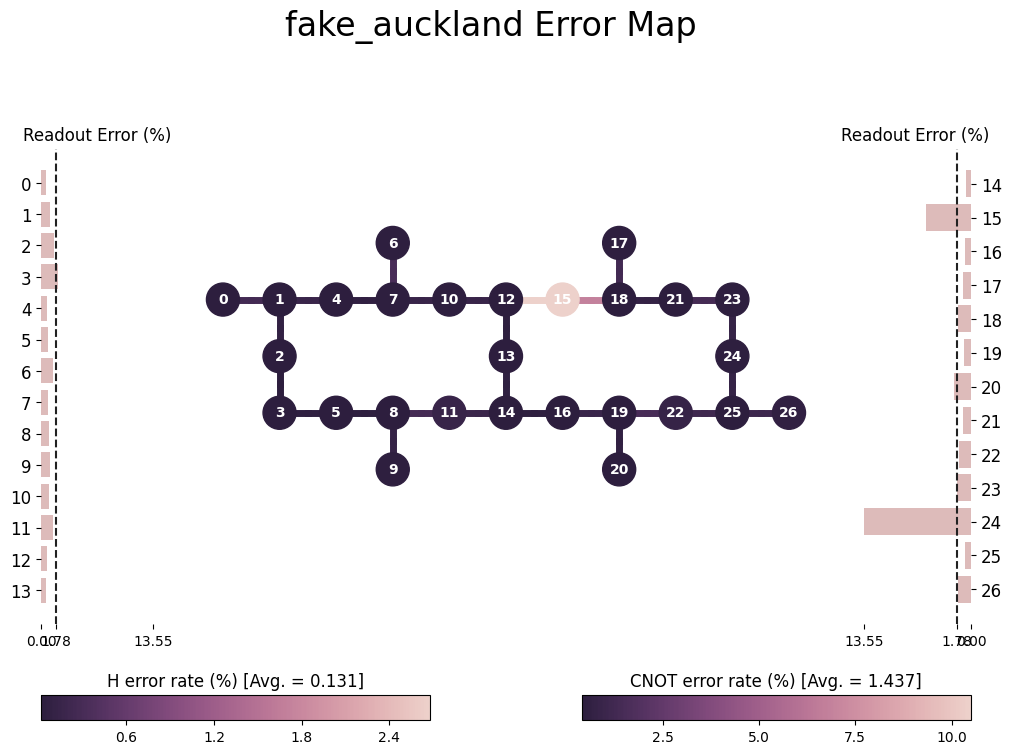

In [28]:
from qiskit.providers.fake_provider import FakeAuckland
from qiskit.visualization import plot_error_map
backend = FakeAuckland()
plot_error_map(backend)

### Step B) Transpiled a circuit for the backend with a smallest circuit depth

In [29]:
qc_transpiled_circuits = []
for i in range(10):
    trans = transpile(qc_final, backend=backend)
    qc_transpiled_circuits.append(trans)

chosen_qc_trans = min(qc_transpiled_circuits,  key=lambda t: t.depth())
print("Chose a transpiled circuit with min circuit depth of {}".format(chosen_qc_trans.depth()))

Chose a transpiled circuit with min circuit depth of 59


### Step C) Simulated results from FakeAuckland QC

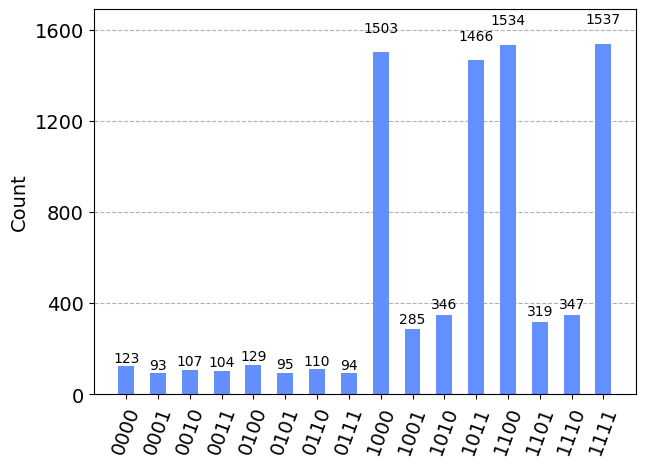

In [39]:
shots = 8192
job = backend.run(chosen_qc_trans, shots=shots)
counts_final = job.result().get_counts()
plot_histogram(counts_final)

### Step D) Fidelity between simulated results and Auckland QC

In [31]:
from qiskit.quantum_info.analysis import hellinger_fidelity

hellinger_fidelity(counts_sim, counts_final)

0.7345794676502314